In [1]:
import torch
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import os
from PIL import Image

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [4]:
folder_path = "Assignment3_dataset/bus"

In [5]:
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

In [6]:
images = []
for file_name in image_files:
    image = Image.open(os.path.join(folder_path, file_name))
    images.append(image)

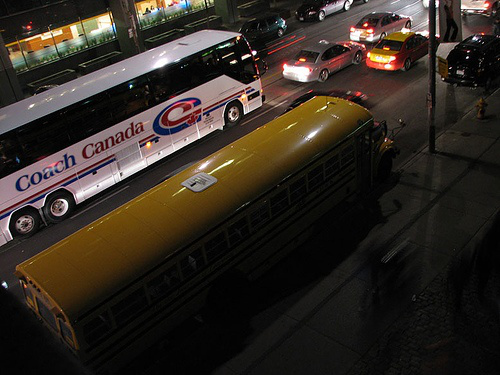

In [7]:
images[0]

In [8]:
print(len(images))

108


In [9]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.Resize((64,64),antialias=True)])
D_transformed=[transform(image) for image in images]
print(D_transformed[0])

tensor([[[-0.9179, -0.9261, -0.9260,  ...,  0.7289,  0.4296, -0.5064],
         [-0.9131, -0.8984, -0.8911,  ...,  0.4861,  0.1224, -0.5857],
         [-0.8702, -0.8276, -0.8231,  ..., -0.3239, -0.4211, -0.6554],
         ...,
         [-0.9716, -0.9725, -0.9689,  ..., -0.9391, -0.9545, -0.9634],
         [-0.9709, -0.9736, -0.9730,  ..., -0.9381, -0.9541, -0.9647],
         [-0.9664, -0.9701, -0.9701,  ..., -0.9434, -0.9517, -0.9583]],

        [[-0.9177, -0.9249, -0.9262,  ...,  0.4791, -0.1348, -0.6886],
         [-0.9136, -0.8966, -0.8929,  ...,  0.3251, -0.2284, -0.7153],
         [-0.8769, -0.8443, -0.8377,  ..., -0.4411, -0.5494, -0.7036],
         ...,
         [-0.9716, -0.9725, -0.9689,  ..., -0.9391, -0.9545, -0.9634],
         [-0.9709, -0.9736, -0.9730,  ..., -0.9381, -0.9541, -0.9647],
         [-0.9664, -0.9701, -0.9701,  ..., -0.9434, -0.9517, -0.9583]],

        [[-0.9205, -0.9287, -0.9294,  ...,  0.3616, -0.2043, -0.7136],
         [-0.9246, -0.9072, -0.9051,  ...,  0

In [10]:
D_train,D_val=train_test_split(D_transformed,test_size=0.1,random_state=42)
print(len(D_train))

97


In [11]:
from torch.utils.data import DataLoader
batch_size = 16
data_loader = DataLoader(D_train, batch_size=batch_size, shuffle=True)
dataIter=iter(data_loader)
imgs=next(dataIter)

In [12]:
imgs.shape

torch.Size([16, 3, 64, 64])

In [13]:
def imshow_RGB(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    imgs = imgs.cpu()
    npimgs = imgs.numpy()
    imgs[0] = imgs[0] * 0.2023 + 0.4914
    imgs[1] = imgs[1] * 0.1994 + 0.4822
    imgs[2] = imgs[2] * 0.2010 + 0.4465
    plt.figure(figsize=(8,8))
    T = torchvision.transforms.Resize((64,64),antialias=True)
    imgs = T(imgs)
    plt.imshow(np.transpose(npimgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

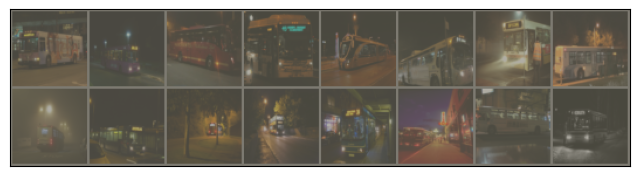

In [14]:
imshow_RGB(imgs) #using imshow() to obtain the grid

In [15]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, image_size=64, channel_num=3, z_size=128):
        super().__init__()
        self.kernel_num = 128
        self.num_encoder_layers = 2

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channel_num, self.kernel_num // 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(self.kernel_num // 2, self.kernel_num, 4, 2, 1),
            nn.ReLU(),
        )

        # Encoded feature's size and volume
        self.feature_size = image_size // (2 ** self.num_encoder_layers)
        self.feature_volume = self.kernel_num * (self.feature_size ** 2)

        self.q_mean = nn.Linear(self.feature_volume, z_size)
        self.q_logvar = nn.Linear(self.feature_volume, z_size)

        # Projection
        self.project = nn.Linear(z_size, self.feature_volume)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.kernel_num, self.kernel_num // 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.kernel_num // 2, channel_num, 4, 2, 1),
            nn.Sigmoid(),  # Add a Sigmoid activation for output in [0, 1] for images
        )

    def forward(self, x):
        # Encode x
        encoded = self.encoder(x)

        mean, logvar = self.q(encoded)
        z = self.z(mean, logvar)
        z_projected = self.project(z).view(
            -1, self.kernel_num, self.feature_size, self.feature_size
        )
        # Reconstruct x from z
        x_reconstructed = self.decoder(z_projected)
        return mean, logvar, x_reconstructed

    def q(self, encoded):
        unrolled = encoded.view(encoded.size(0), -1)
        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.MSELoss(reduction='sum')(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return (-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())) / mean.size(0)


In [16]:
model = VAE()
optimizer_vae = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [32]:
def train(epoch):
    train_loss = 0
    recon_loss = 0
    kl_loss = 0
    recon_batch = None
    for batch_idx, data in enumerate(data_loader):
            optimizer_vae.zero_grad()
            mu, logvar, recon_batch = model(data)


            reconstruction_loss = model.reconstruction_loss(recon_batch, data)
            kl_divergence_loss = model.kl_divergence_loss(mu, logvar)
            recon_loss += reconstruction_loss.item()
            loss = reconstruction_loss + kl_divergence_loss #+ 100*quantile_loss
            kl_loss += kl_divergence_loss.item()
            loss.backward()
            train_loss += loss.item()
            optimizer_vae.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / (len(data_loader)*20)))
    print('====> Epoch: {} Average Reconstruction loss: {:.4f}'.format(
        epoch, recon_loss / (len(data_loader)*20)))
    print('====> Epoch: {} Average KL loss: {:.4f}'.format(
        epoch, kl_loss / (len(data_loader)*20)))

    if epoch%5 == 0:
        print(color.BOLD + 'Original Samples:' + color.END)
        imshow_RGB(torchvision.utils.make_grid(data.cpu()))
        print(color.BOLD + 'Generated Generated:' + color.END)
        imshow_RGB(torchvision.utils.make_grid(recon_batch.view(3,64,64).detach().cpu()))


In [ ]:
epochs = 100
for epoch in range(1, epochs + 1):
    train(epoch)